# Uncofoundedness

We call 'Uncofoundedness' a scenario where a treatment is not randomly assigned to participants, so confounders effect on treatment assignment and outcome. We have client - level data. Confounders were measured before treatment and outcome after

# Data

Let's look at the example:

In our ecosystem we have a product, which effect on LTV we want to estimate

Treatment - first purchase in product.

Outcome - LTV after first purchase.

We will test hypothesis:

$H_o$ - There is no difference in LTV between treatment and control groups.

$H_a$ - There is a difference in LTV between treatment and control groups.

We will use DGP from Causalis. Read more at https://causalis.causalcraft.com/articles/generate_obs_hte_26_rich

In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_26_rich

data = generate_obs_hte_26_rich(return_causal_data=False, include_oracle=True)
data.head()

,y,d,tenure_months,avg_sessions_week,spend_last_month,age_years,income_monthly,prior_purchases_12m,support_tickets_90d,premium_user,mobile_user,urban_resident,referred_user,m,m_obs,tau_link,g0,g1,cate
0,0.000000,0.0,28.814654,1.0,77.936767,50.234101,1926.698301,1.0,2.0,1.0,1.0,1.0,0.0,0.045453,0.045453,0.089095,8.137981,9.142395,1.004414
1,80.099611,1.0,25.913345,3.0,53.777740,28.115859,5104.271509,3.0,0.0,1.0,1.0,0.0,1.0,0.041514,0.041514,0.246679,60.459257,78.817307,18.358049
2,6.400482,1.0,24.969929,10.0,134.764322,22.907062,5267.938255,8.0,3.0,0.0,1.0,1.0,0.0,0.052593,0.052593,0.162968,7.712855,9.138577,1.425723
3,2.788238,0.0,40.655089,5.0,59.517074,31.970490,6597.327018,3.0,2.0,1.0,1.0,1.0,0.0,0.036221,0.036221,0.188755,25.386510,31.159932,5.773422
4,0.000000,0.0,18.560899,3.0,74.370930,39.237248,4930.009628,5.0,1.0,1.0,1.0,0.0,0.0,0.036343,0.036343,0.174757,15.359250,18.600227,3.240977


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 19.409586529660793
Ground truth ATTE is 10.914991423363865


In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months',
                                     'avg_sessions_week',
                                     'spend_last_month',
                                     'age_years',
                                     'income_monthly',
                                     'prior_purchases_12m',
                                     'support_tickets_90d',
                                     'premium_user',
                                     'mobile_user',
                                     'urban_resident',
                                     'referred_user'])
causaldata

CausalData(df=(100000, 13), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'age_years', 'income_monthly', 'prior_purchases_12m', 'support_tickets_90d', 'premium_user', 'mobile_user', 'urban_resident', 'referred_user'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,95051,76.087138,240.800713,0.0,0.0,0.0,8.39544,64.859278,190.227900,21396.007575
1,1.0,4949,58.506172,199.485625,0.0,0.0,0.0,0.00000,36.958280,148.837193,5143.642132


Our data has strong treatment class disbalance. Only 5% of sample activated in treatment.

Treatment group has lower mean LTV. It's too early to draw conclusions.

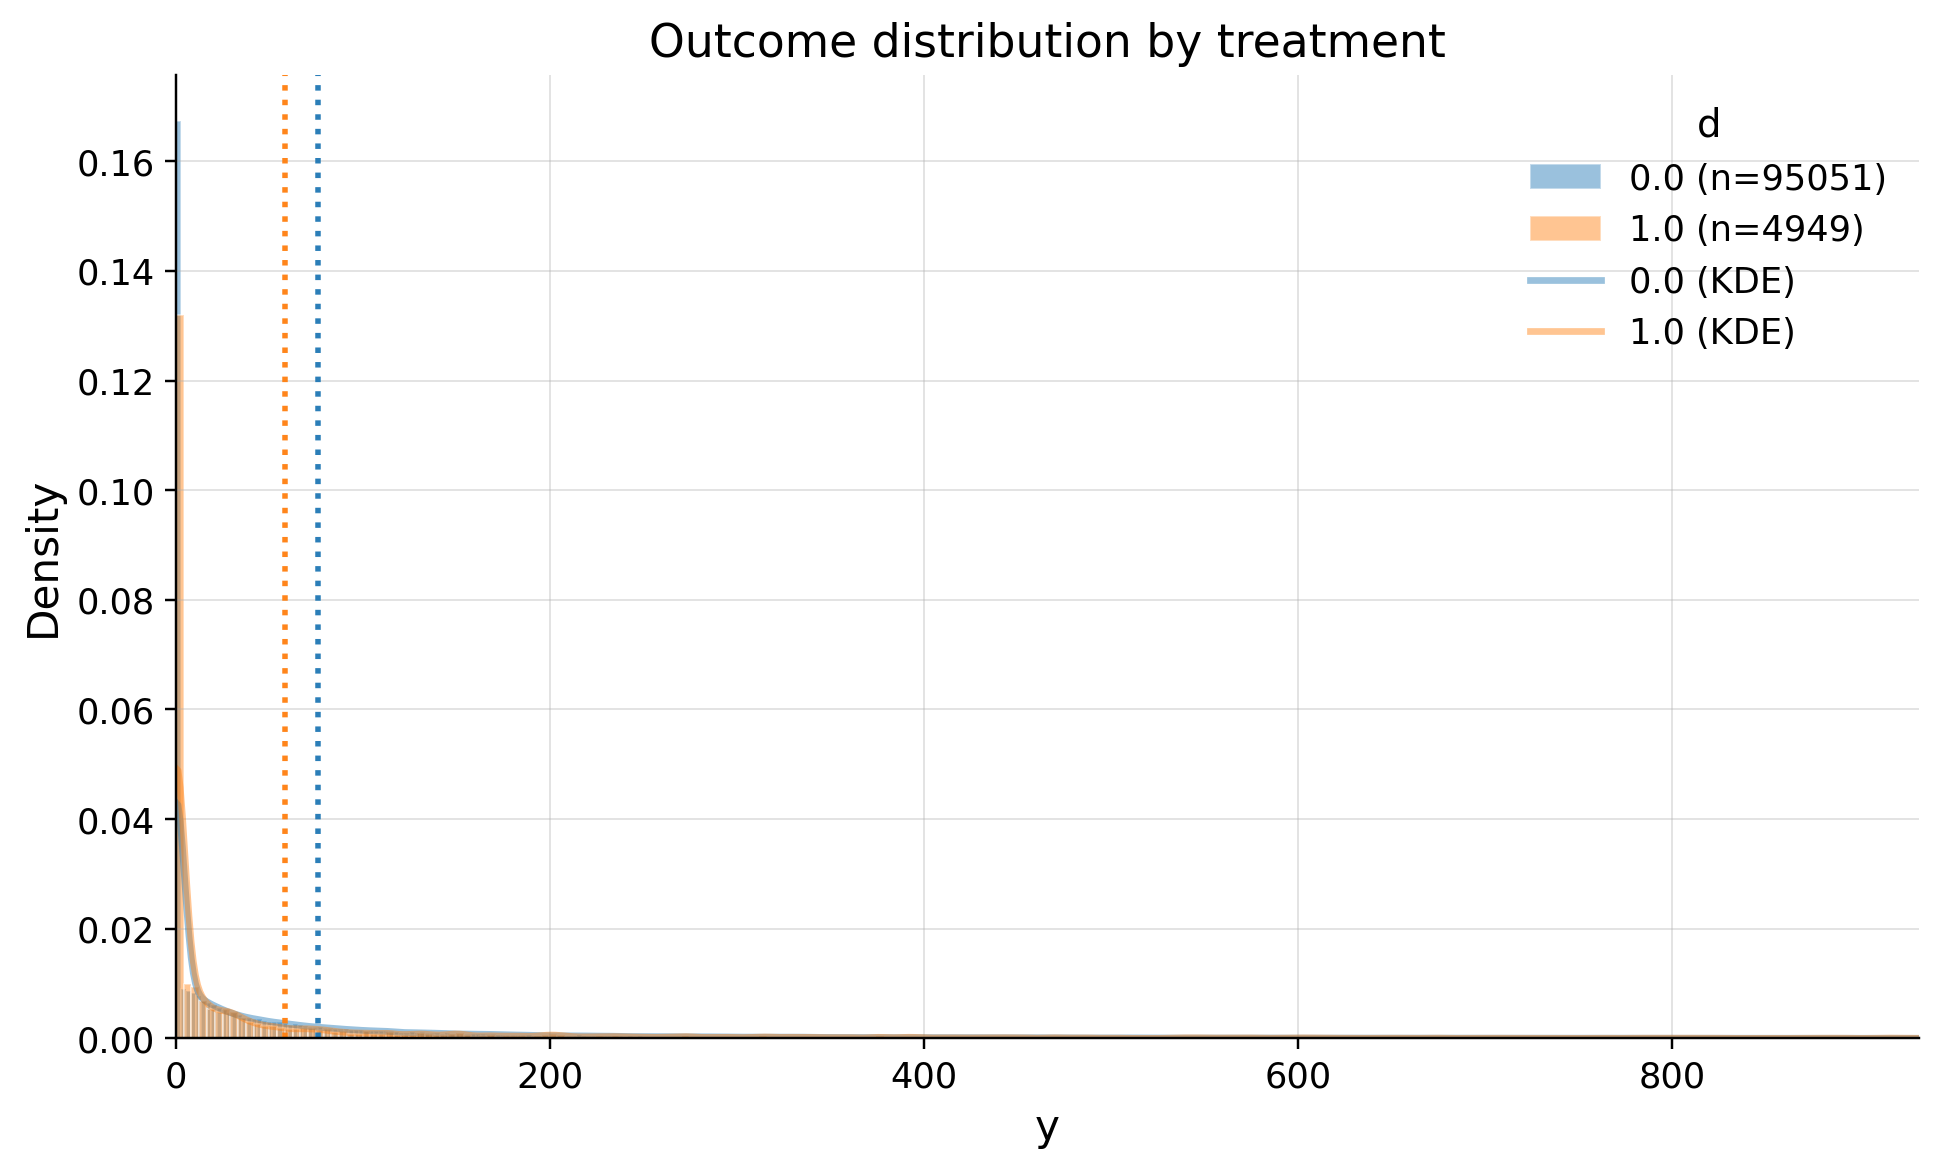

In [5]:
from causalis.shared.outcome_plots import outcome_plot_dist
outcome_plot_dist(causaldata)

We see large right tale

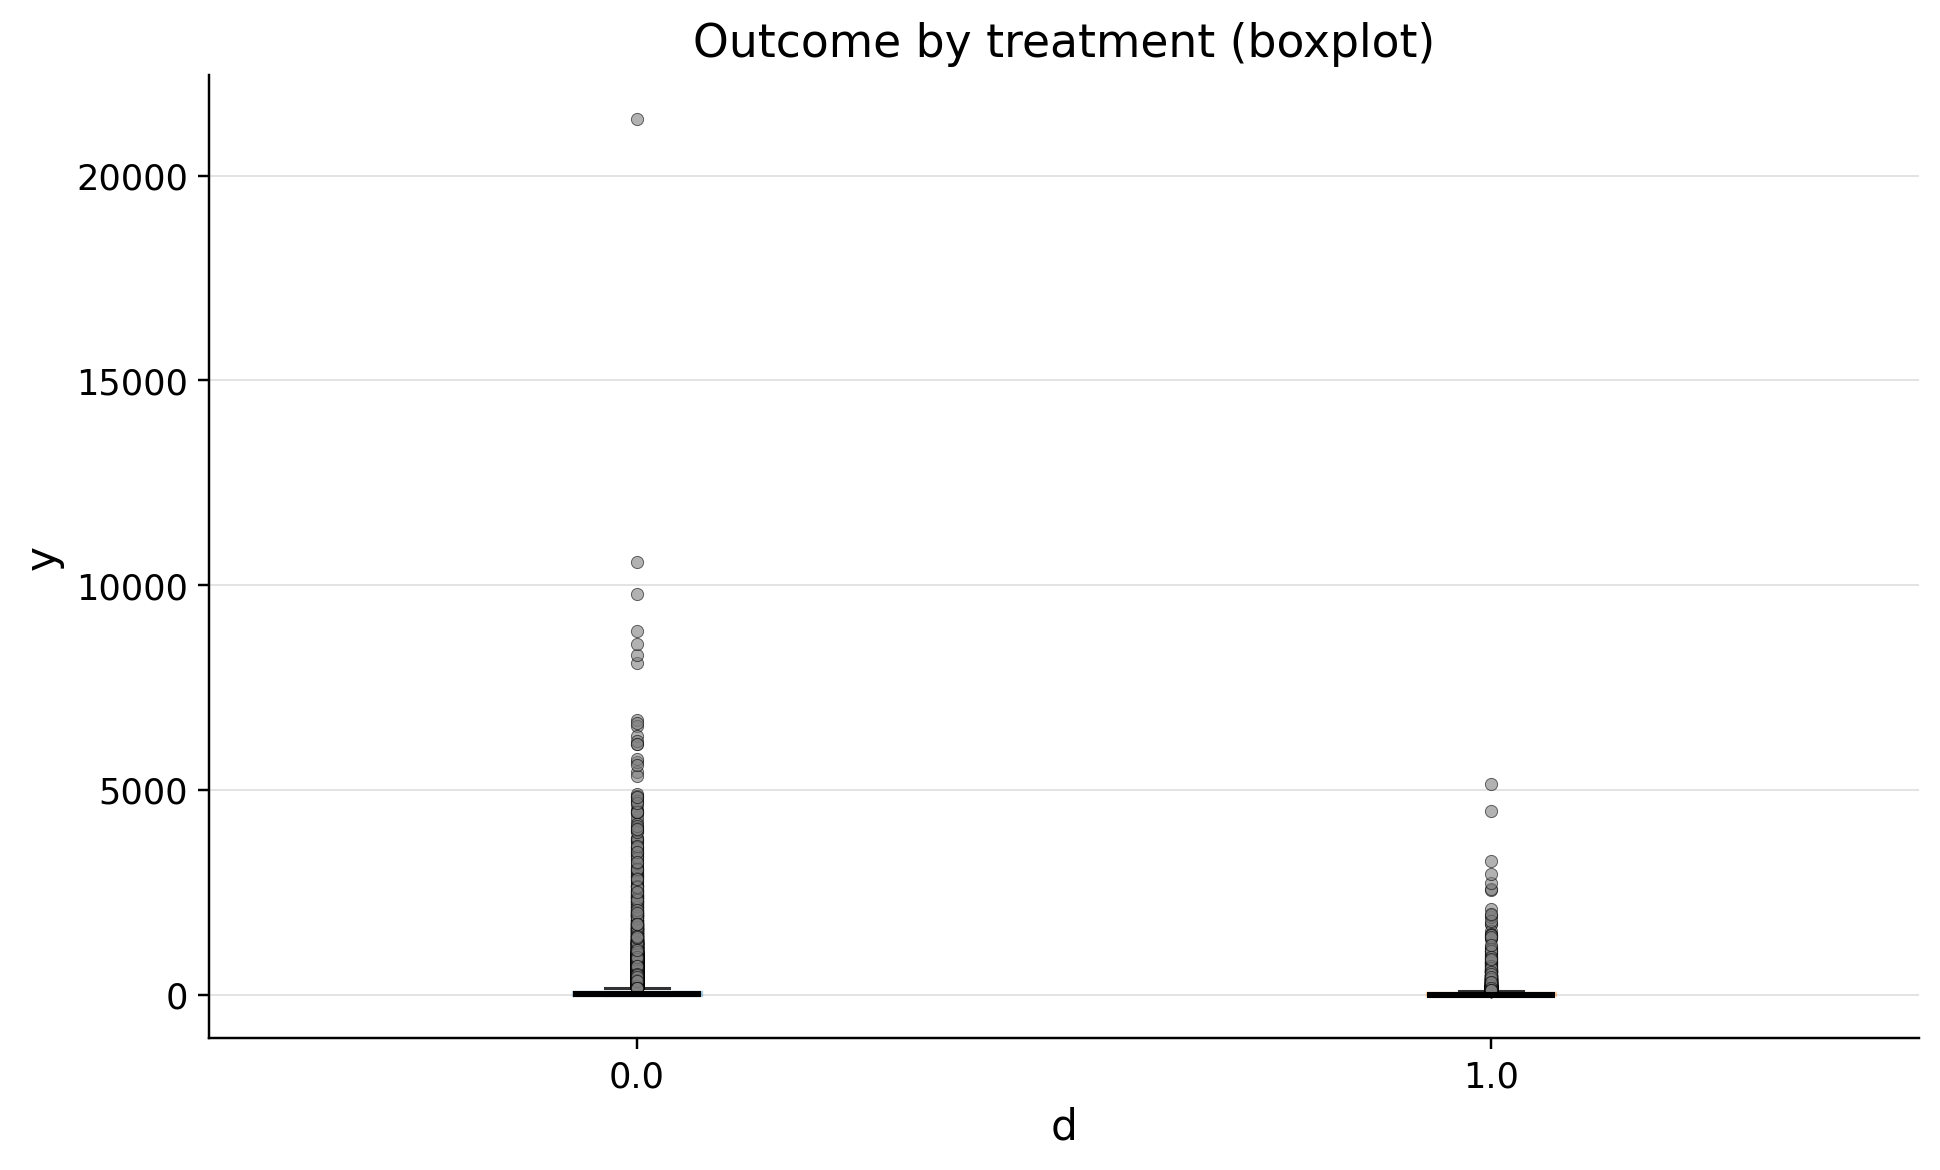

In [6]:
from causalis.shared.outcome_plots import outcome_plot_boxplot
outcome_plot_boxplot(causaldata)

In [7]:
from causalis.shared import outcome_outliers

outcome_outliers(causaldata)

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,0.0,95051,11300,0.118884,-97.288916,162.148194,True,iqr,both
1,1.0,4949,721,0.145686,-55.437420,92.395699,True,iqr,both


We see many outliers. It's common situation for LTV metric. Dropping them will lead to a biased conclusion

In [8]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,premium_user,0.751807,0.591837,0.159970,-0.345721,0.00000
1,income_monthly,4549.385190,3918.058798,631.326392,-0.277611,0.00000
2,spend_last_month,89.091801,67.375389,21.716412,-0.268360,0.00000
3,support_tickets_90d,0.984545,1.259244,0.274699,0.253974,0.00000
4,avg_sessions_week,5.047753,4.230148,0.817606,-0.201735,0.00000
5,prior_purchases_12m,3.904220,3.513639,0.390581,-0.189372,0.00000
6,tenure_months,28.740100,25.559161,3.180939,-0.184156,0.00000
7,age_years,36.435984,34.809083,1.626901,-0.144142,0.00000
8,referred_user,0.271486,0.307133,0.035647,0.078671,0.00001
9,urban_resident,0.600793,0.568802,0.031991,-0.064954,0.00013


As we see clients are differ on this confounders. We need to controll them to make causal inference

# Inference

ATTE is right estimand here. We will estimate effect on clients that were treated, had first purchase in our product

In [9]:
from causalis.scenarios.unconfoundedness import IRM

model = IRM().fit(causaldata)

## Math Explanation of the IRM Model and ATTE Estimand


The **Interactive Regression Model (IRM)** is a flexible framework used in Double Machine Learning (DML) to estimate treatment effects. Unlike linear models, it allows the treatment effect to vary with confounders $X$ (interaction) and makes no parametric assumptions about the functional forms of the outcomes.

We write $W=(Y,D,X)$ for an observation, where $D\in\{0,1\}$ is treatment and $Y$ is the observed outcome.



## 1. Nuisance Functions


The IRM framework relies on three "nuisance" components estimated from the data:
*   **Outcome Regression (Control):** $g_0(X) = \mathbb{E}[Y | X, D=0]$
*   **Outcome Regression (Treated):** $g_1(X) = \mathbb{E}[Y | X, D=1]$
*   **Propensity Score:** $m(X) = \mathbb{P}(D=1 | X)$

Let $p = \mathbb{P}(D=1) = \mathbb{E}[D]$ denote the overall treatment rate (estimated by the sample mean of $D$).

In the provided implementation (`irm.py`), these are estimated using cross-fitting (splitting data into folds) to avoid overfitting bias.



## 2. ATTE (Average Treatment Effect on the Treated)


The **Average Treatment Effect on the Treated (ATTE)** measures the impact of the treatment specifically on those individuals who received it:
$$\theta_{ATTE} = \mathbb{E}[Y(1) - Y(0) \mid D=1]$$

Under **unconfoundedness**, $(Y(1),Y(0)) \perp D \mid X$, and overlap $0 < m(X) < 1$, this is identified from observed data.



## 3. The Orthogonal Score


DML uses a **Neyman-orthogonal score** $\psi$ to ensure the estimator is robust to small errors in the nuisance function estimates. The score for ATTE is defined as:
$$\psi(W; \theta, \eta) = \psi_b(W; \eta) + \psi_a(W; \eta)\theta$$

To match the implementation in `irm.py`, define:
*   **Residuals:** $u_0 = Y - g_0(X)$, $u_1 = Y - g_1(X)$
*   **IPW terms:** $h_1 = \frac{D}{m(X)}$, $h_0 = \frac{1-D}{1-m(X)}$
*   **Weights (ATTE):** $w = \frac{D}{p}$ and $\bar{w} = \frac{m(X)}{p}$ (the normalized form with $\mathbb{E}[w]=1$)

Then:
$$
\begin{aligned}
\psi_a(W;\eta) &= -w = -\frac{D}{p} \\
\psi_b(W;\eta) &= w\,(g_1(X)-g_0(X)) + \bar{w}\,(u_1 h_1 - u_0 h_0)
\end{aligned}
$$
(If `normalize_ipw=True`, the code rescales $h_1$ and $h_0$ to have mean 1.)



## 4. Final Estimation (Step-by-step simplification)


For brevity, write $m = m(X)$, $g_0 = g_0(X)$, and $g_1 = g_1(X)$. Plug in $w, \bar{w}, h_1, h_0$:
$$
\begin{aligned} \psi_b &= \frac{D}{p}(g_1-g_0)•
\frac{m}{p}\left[\frac{D}{m}(Y-g_1) - \frac{1-D}{1-m}(Y-g_0)\right] \ &= \frac{D}{p}(g_1-g_0) + \frac{D}{p}(Y-g_1) - \frac{m}{p}\frac{1-D}{1-m}(Y-g_0) \ &= \frac{D}{p}(Y-g_0) - \frac{m}{p}\frac{1-D}{1-m}(Y-g_0). \end{aligned}
$$
So the $g_1(X)$ terms cancel, and the ATTE score depends only on $g_0(X)$ and $m(X)$.
The estimator solves $\mathbb{E}[\psi(W;\theta,\eta)]=0$:

$$
 \begin{aligned} \hat{\theta}_{ATTE} &= \frac{\mathbb{E}[\psi_b]}{\mathbb{E}[-\psi_a]} = \frac{\mathbb{E}[\psi_b]}{\mathbb{E}[D/p]} = \mathbb{E}[\psi_b]. \end{aligned}
 $$
Equivalently,
$$ \hat{\theta}_{ATTE} = \mathbb{E}\left[\frac{D}{p}(Y-g_0(X)) - \frac{m(X)}{p}\frac{1-D}{1-m(X)}(Y-g_0(X))\right]. $$



In [10]:
dml_result = model.estimate(score='ATTE')
dml_result.summary()

,value
field,
estimand,ATTE
model,IRM
value,"11.6423 (ci_abs: 7.3357, 15.9489)"
value_relative,"24.8428 (ci_rel: 15.6993, 33.9863)"
alpha,0.0500
p_value,0.0000
is_significant,True
n_treated,4949
n_control,95051


Our estimate is 12.1542 dollars (ci_abs: 7.7933, 16.5152). Mean in treatment group is 58.5062 dollars, so without our product it would be 46.3520 dollars.

# Refutation

## Unconfoundedness

In [11]:
from causalis.scenarios.unconfoundedness.refutation.unconfoundedness.unconfoundedness_validation import run_unconfoundedness_diagnostics

rep_uc = run_unconfoundedness_diagnostics(causaldata ,dml_result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,0.012649,GREEN
1,balance_frac_violations,0.000000,GREEN


balance_max_smd is 0.011635 so dml specification dealt with controlling confounders

### Sensitivity

In [12]:
from causalis.scenarios.unconfoundedness.refutation.unconfoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

In [13]:
sensitivity_benchmark(dml_result, benchmarking_set =['tenure_months'])

,r2_y,r2_d,rho,theta_long,theta_short,delta
d,0.000096,0.046444,1.0,11.642302,12.657514,-1.015211


In [14]:
sensitivity_analysis(dml_result, r2_y=0.000079, r2_d=0.048984, rho=1.0, alpha=0.05)

{'theta': 11.64230249515416,
 'se': 2.197307403224961,
 'alpha': 0.05,
 'z': 1.959963984540054,
 'H0': 0.0,
 'sampling_ci': (7.335659121870007, 15.948945868438313),
 'theta_bounds_cofounding': (9.95438377651526, 13.330221213793061),
 'bias_aware_ci': (5.646801764530583, 17.64215573219203),
 'max_bias_base': 836.7343863554829,
 'max_bias': 1.6879187186389004,
 'bound_width': 1.6879187186389004,
 'sigma2': 33948.46797100918,
 'nu2': 20.623152535412455,
 'rv': 0.013723034411667896,
 'rva': 0.00869081797319489,
 'params': {'r2_y': 7.9e-05,
  'r2_d': 0.048984,
  'rho': 1.0,
  'use_signed_rr': False}}

Even if we have latent confounder as strong as 'tenure_months' our estimate will be > 0 with bias_aware_ci': (4.646164852659804, 18.5265291001404)

## SUTVA

In [15]:
from causalis.shared import print_sutva_questions
print_sutva_questions()

1.) Are your clients independent (i). Outcome of ones do not depend on others?
2.) Are all clients have full window to measure metrics?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


SUTVA is untestable from data alone, so we call it true by design

## Score

In [16]:
from causalis.scenarios.unconfoundedness.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(causaldata, dml_result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,2.197307,NA
1,psi_p99_over_med,65.592325,RED
2,psi_kurtosis,2581.689388,RED
3,max_|t|_g1,0.000000,GREEN
4,max_|t|_g0,0.844947,GREEN
5,max_|t|_m,1.421736,GREEN
6,oos_tstat_fold,0.000088,GREEN
7,oos_tstat_strict,0.000088,GREEN


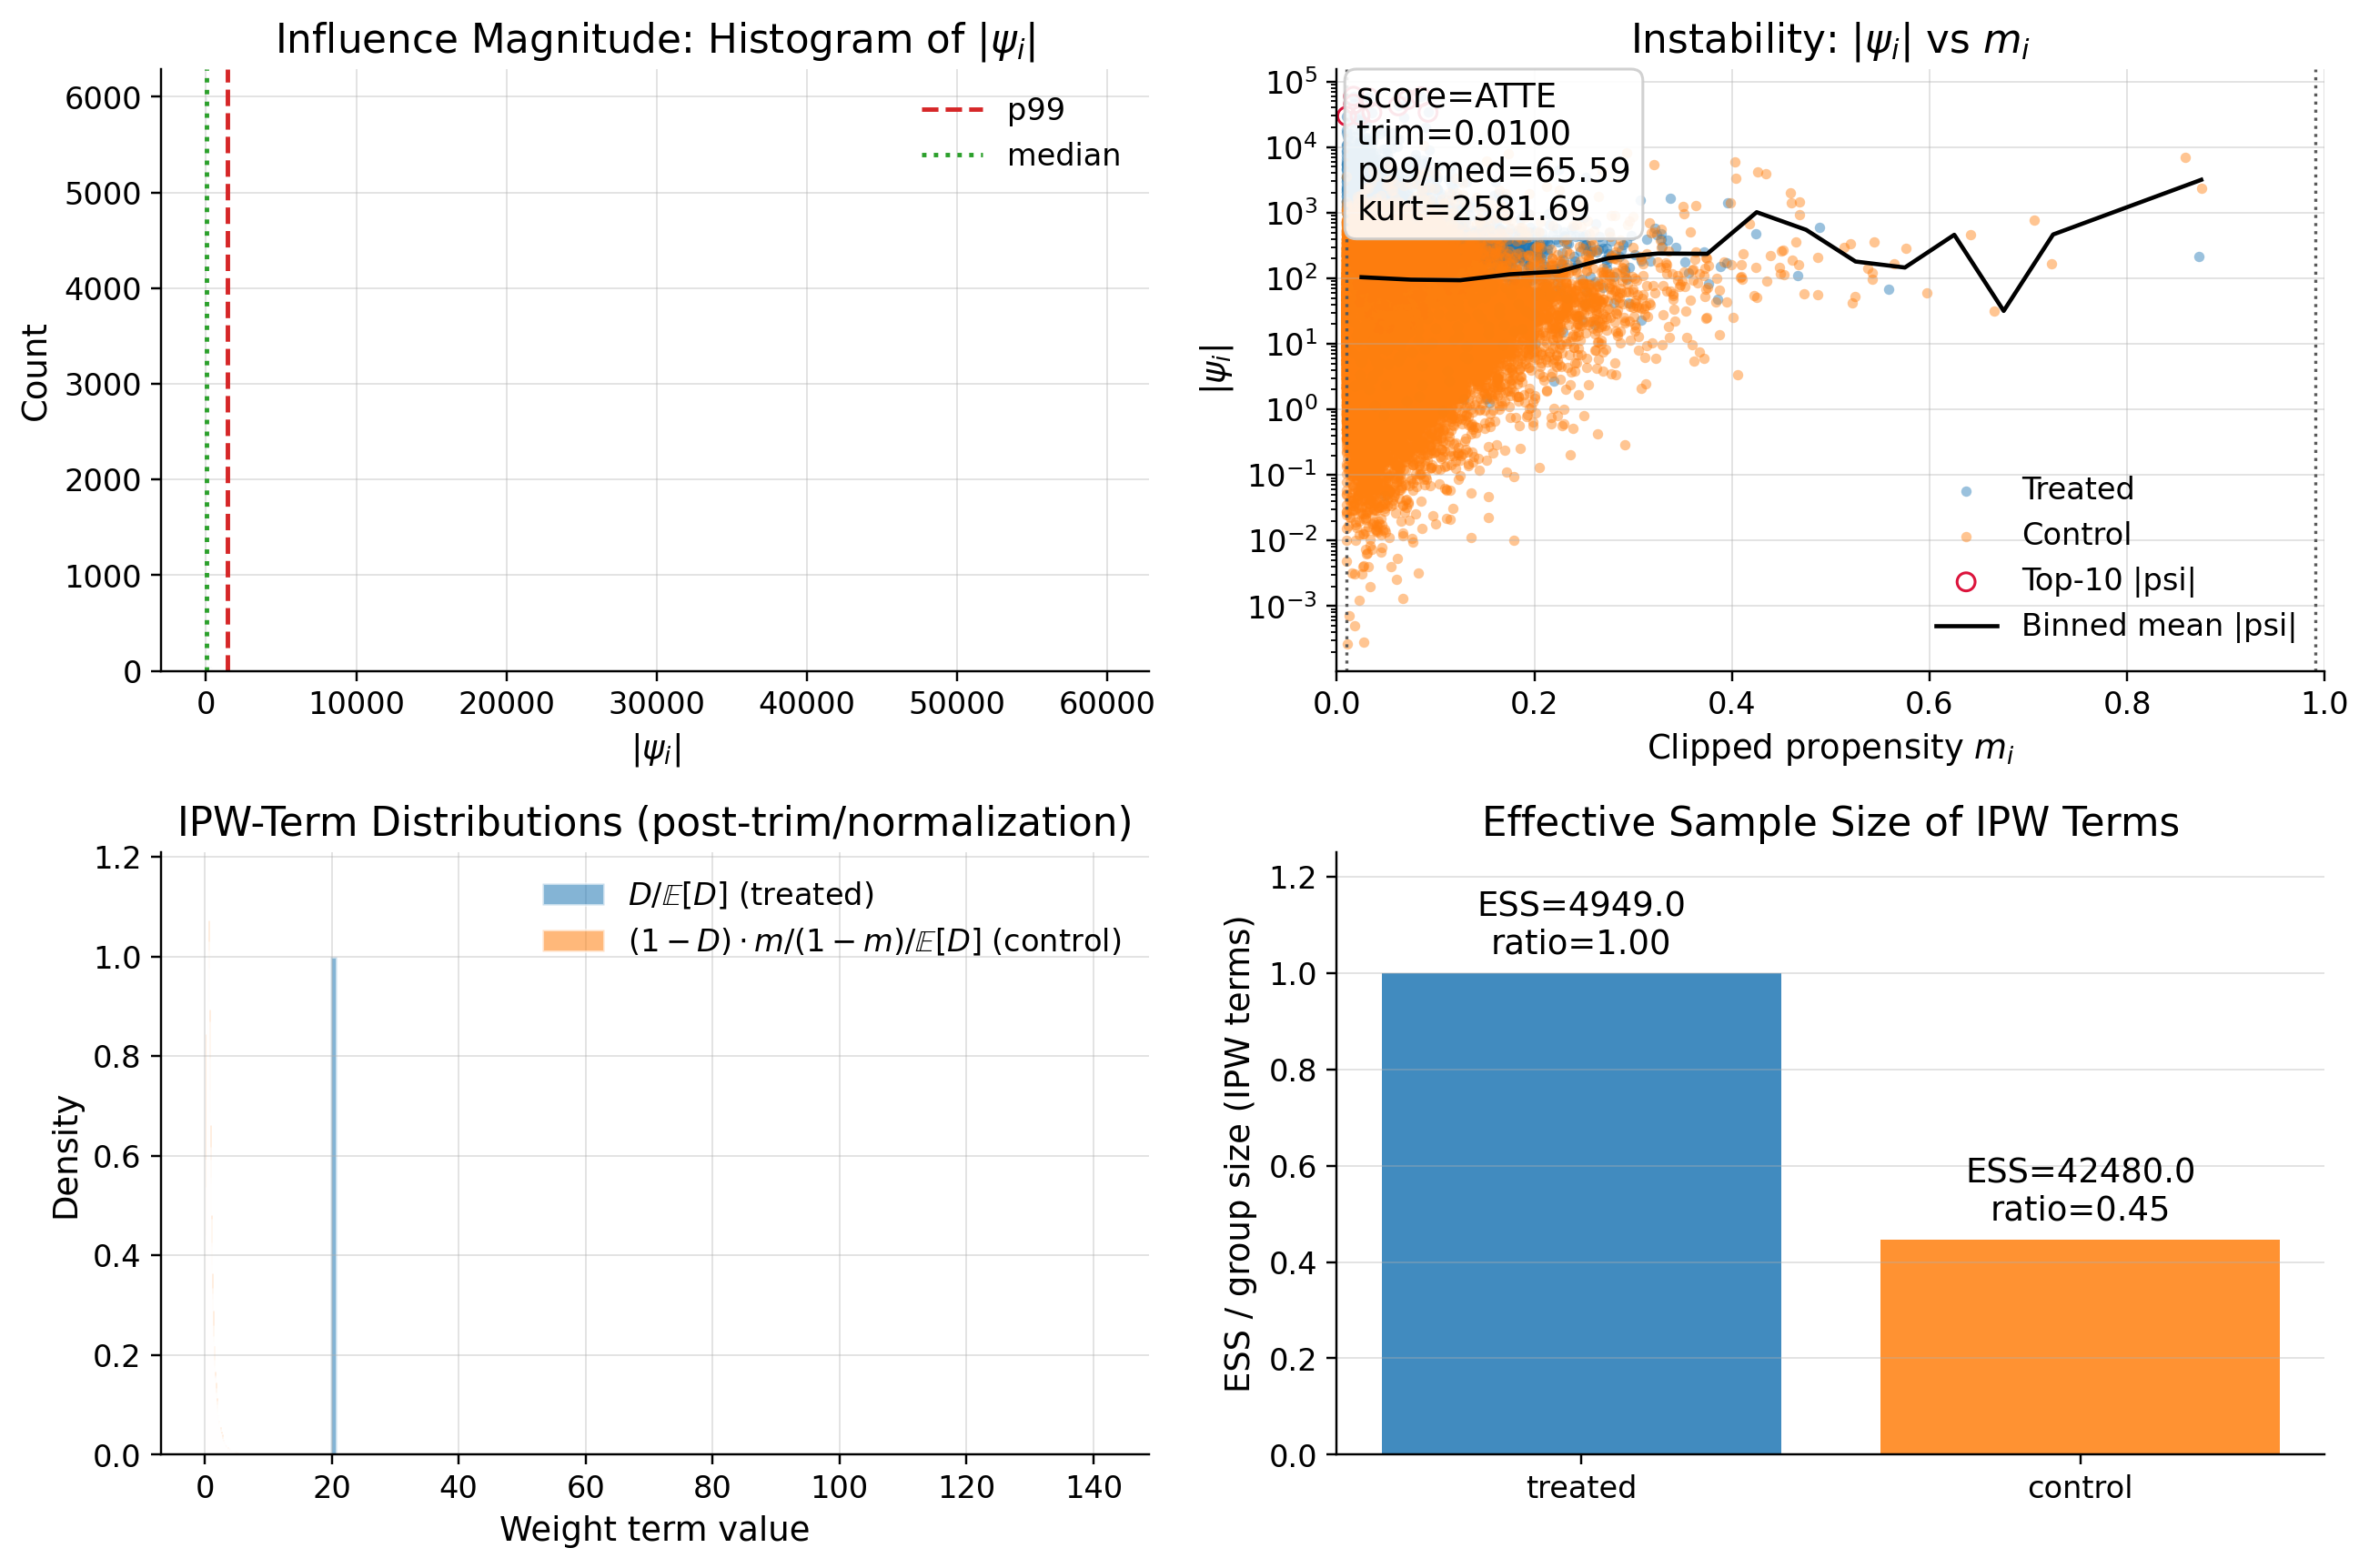

In [17]:
from causalis.scenarios.unconfoundedness.refutation import plot_influence_instability
plot_influence_instability(dml_result)

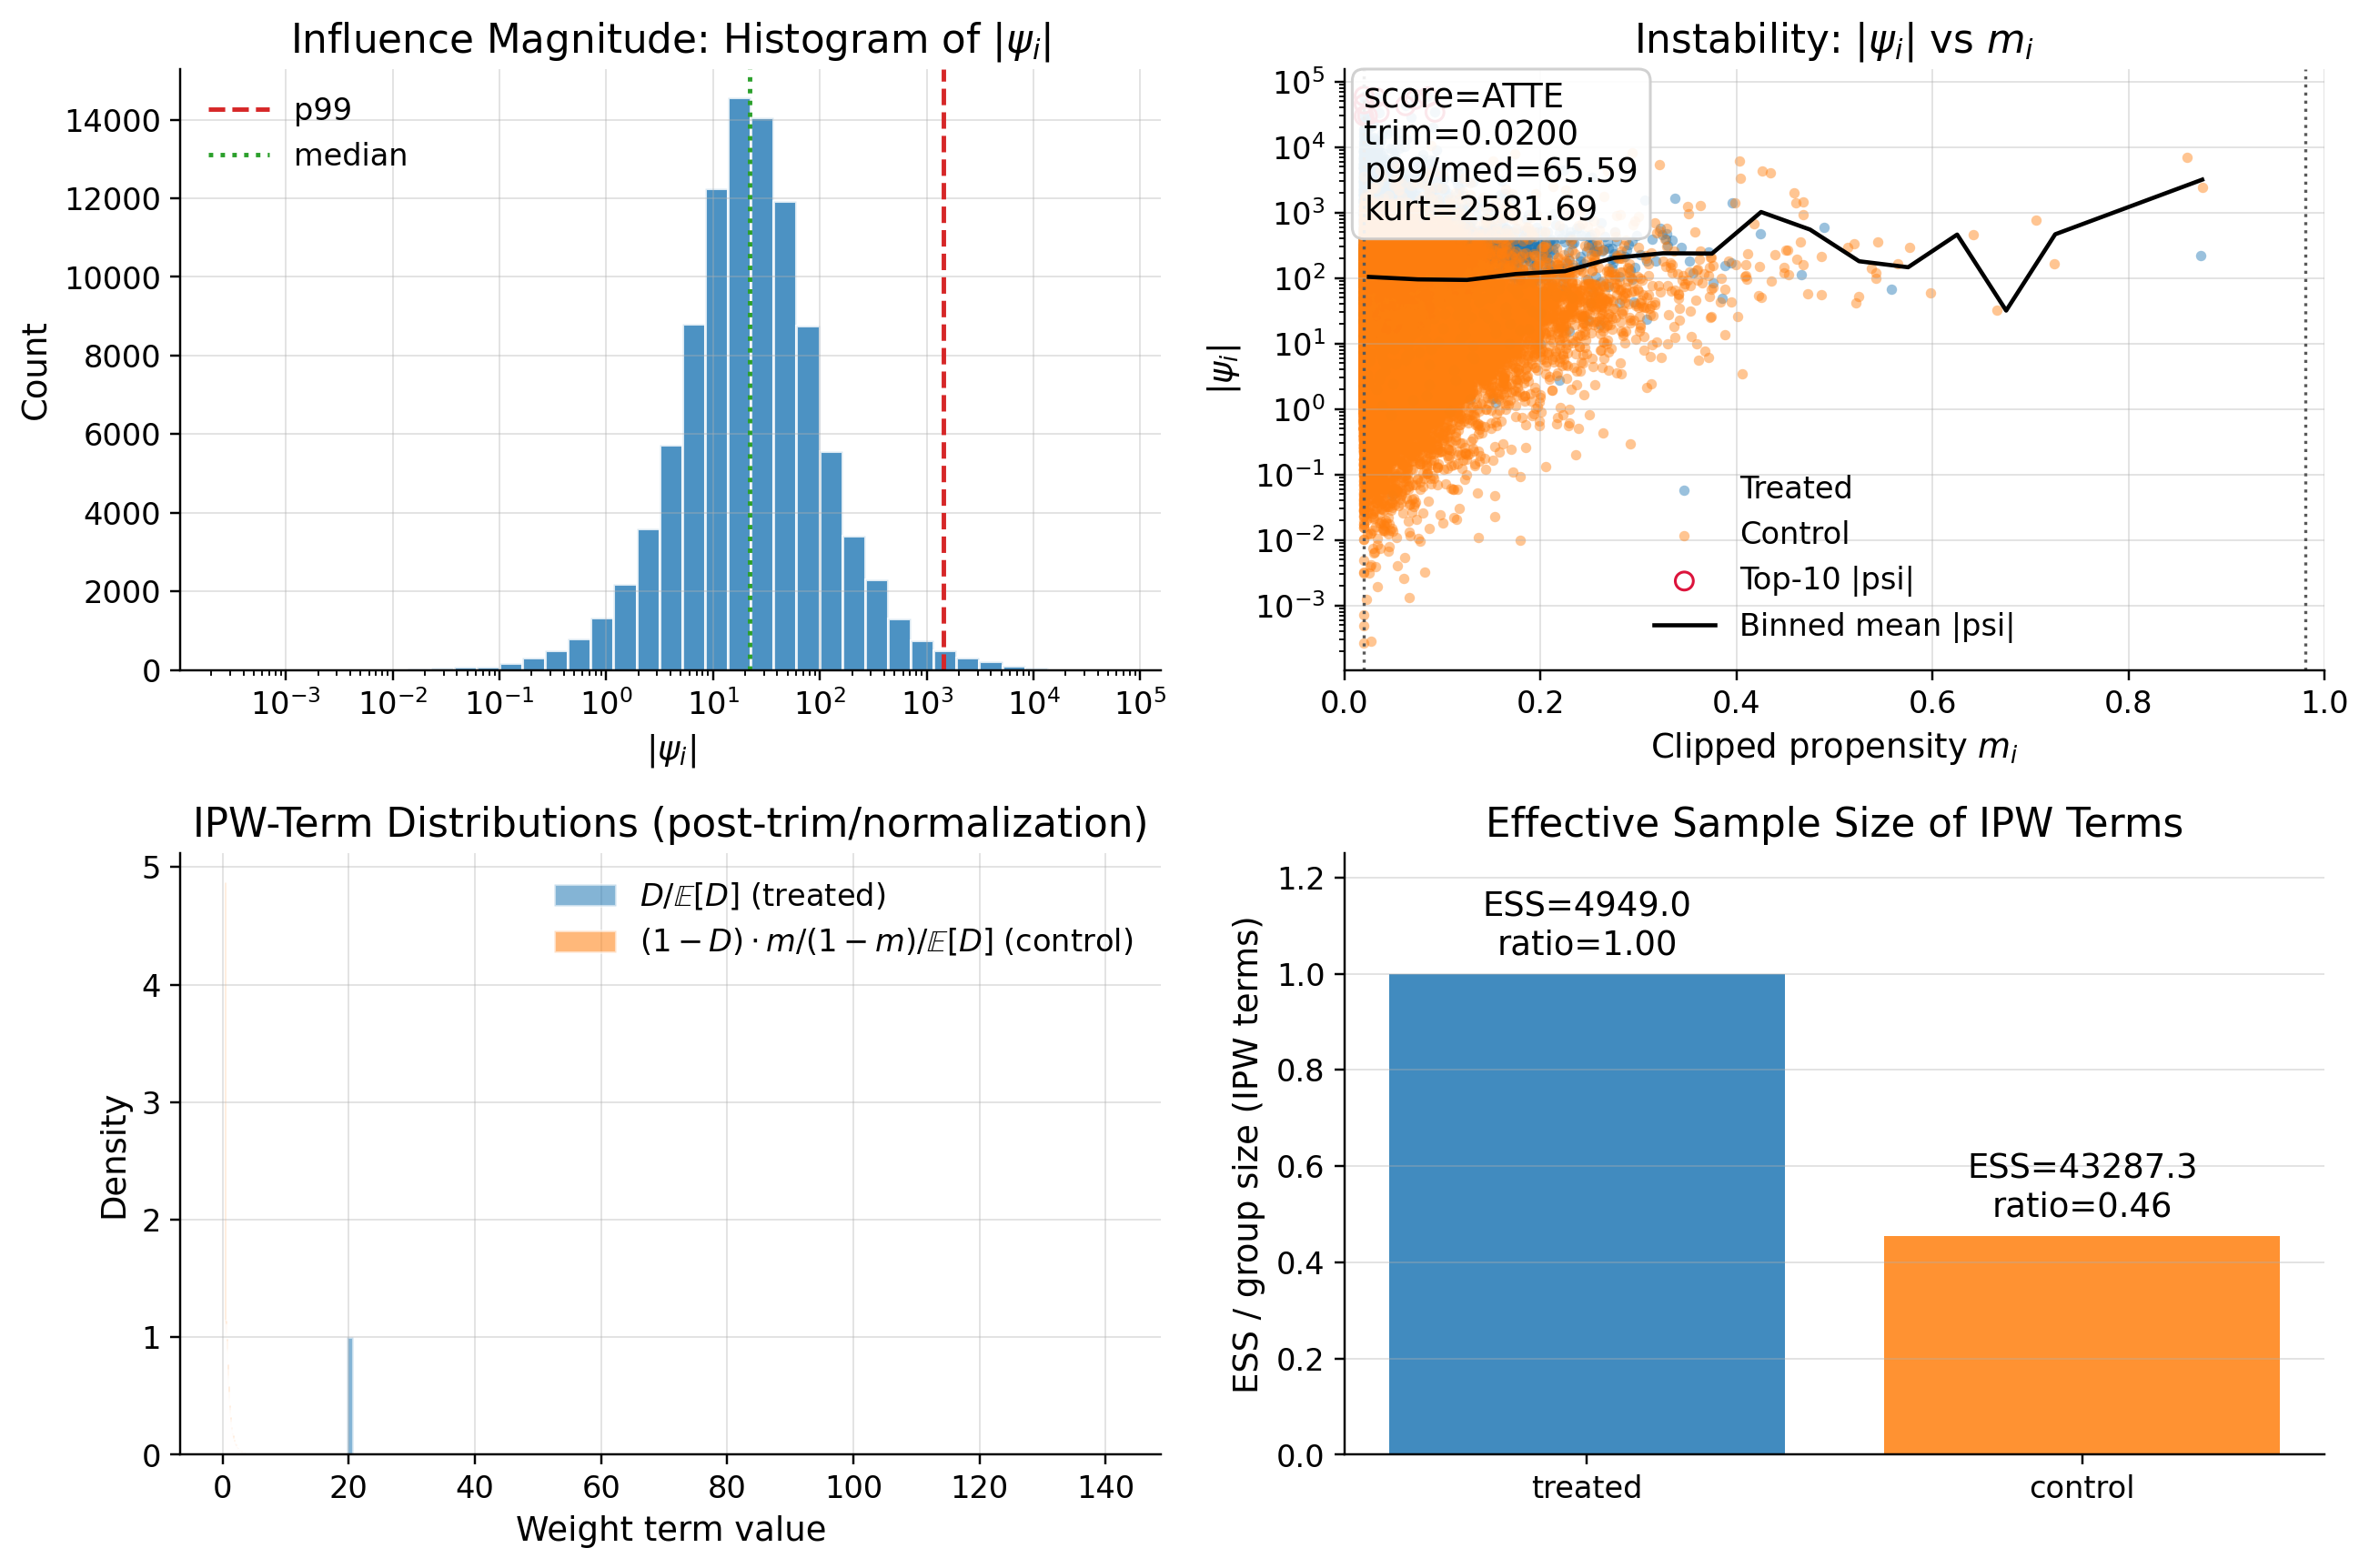

In [18]:
plot_influence_instability(dml_result, log_hist=True, trimming_threshold=0.02)

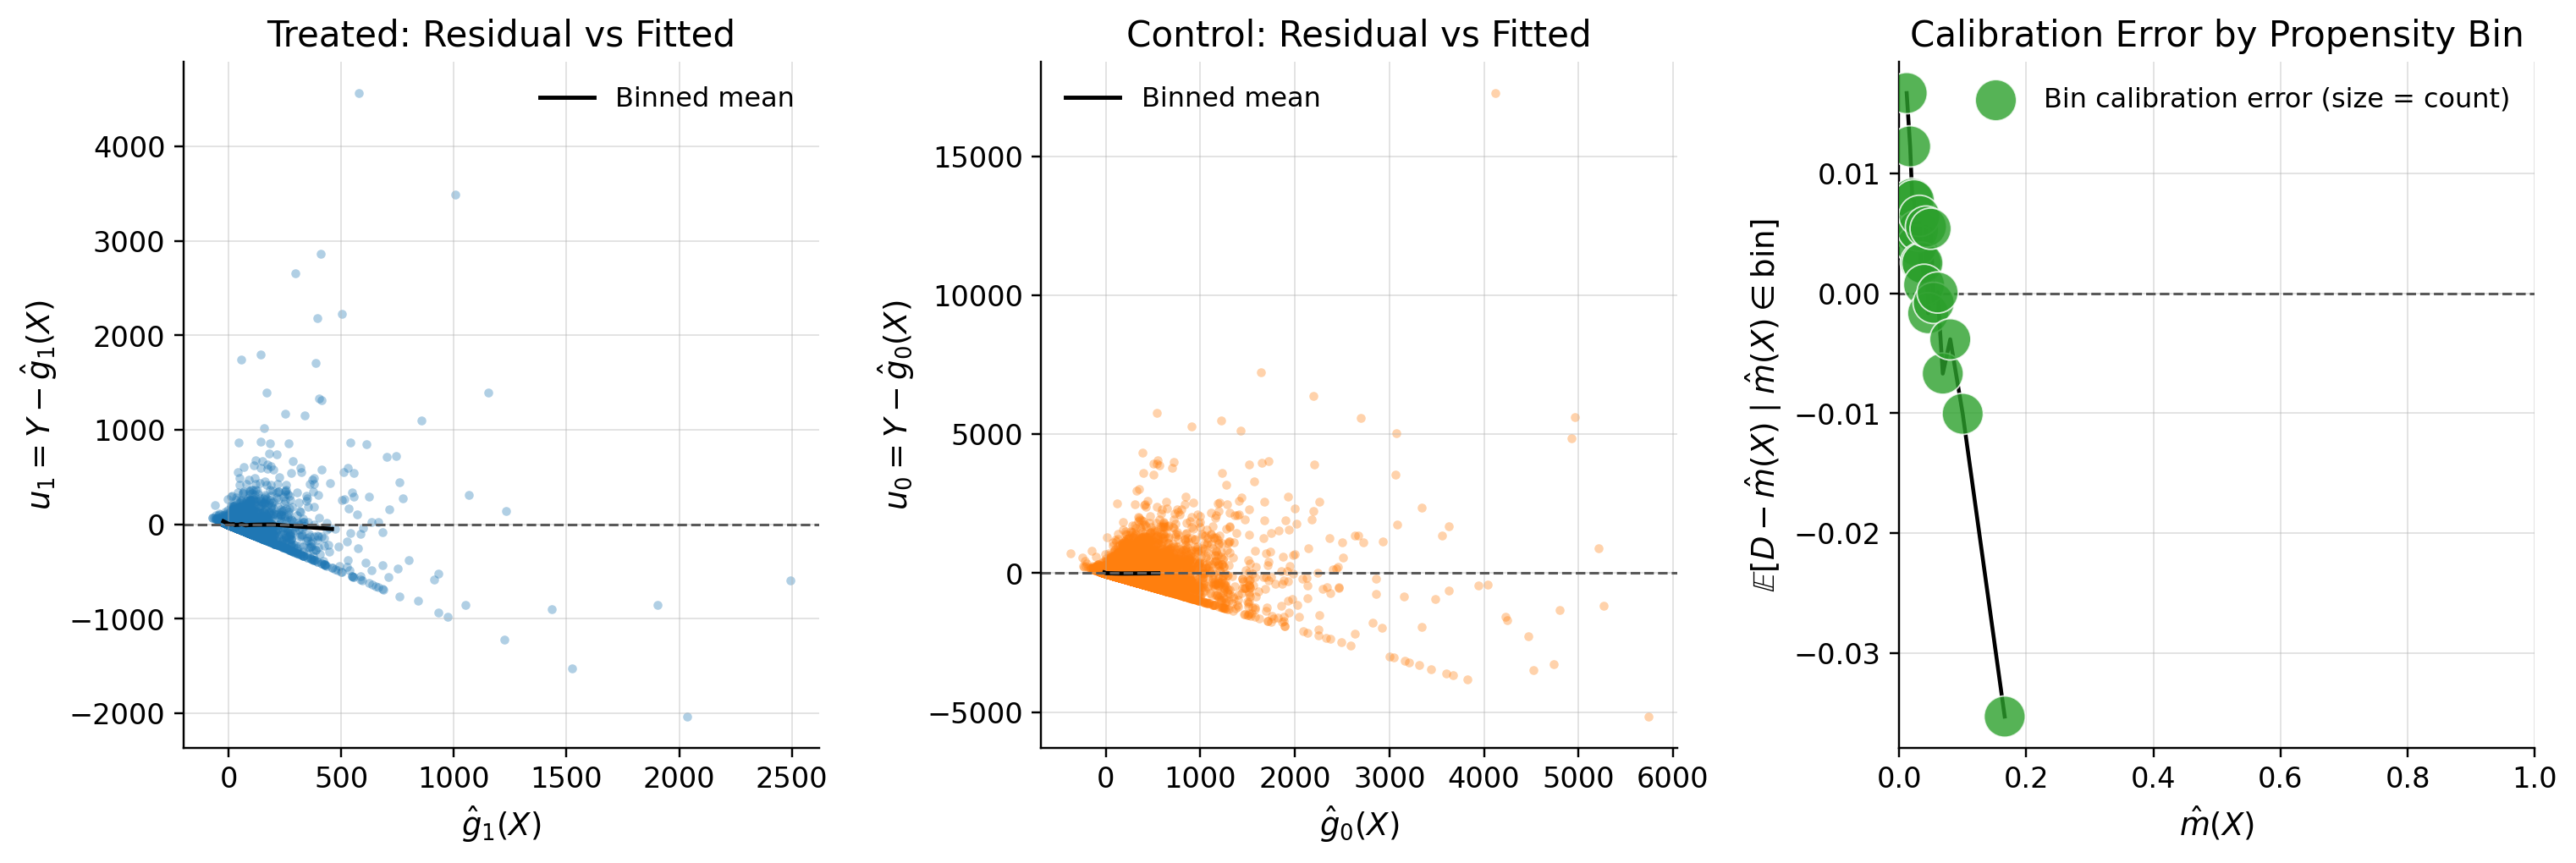

In [19]:
from causalis.scenarios.unconfoundedness.refutation import plot_residual_diagnostics
plot_residual_diagnostics(dml_result)

DML is specified correctly. There are many outliers in data that effect the score

## Overlap

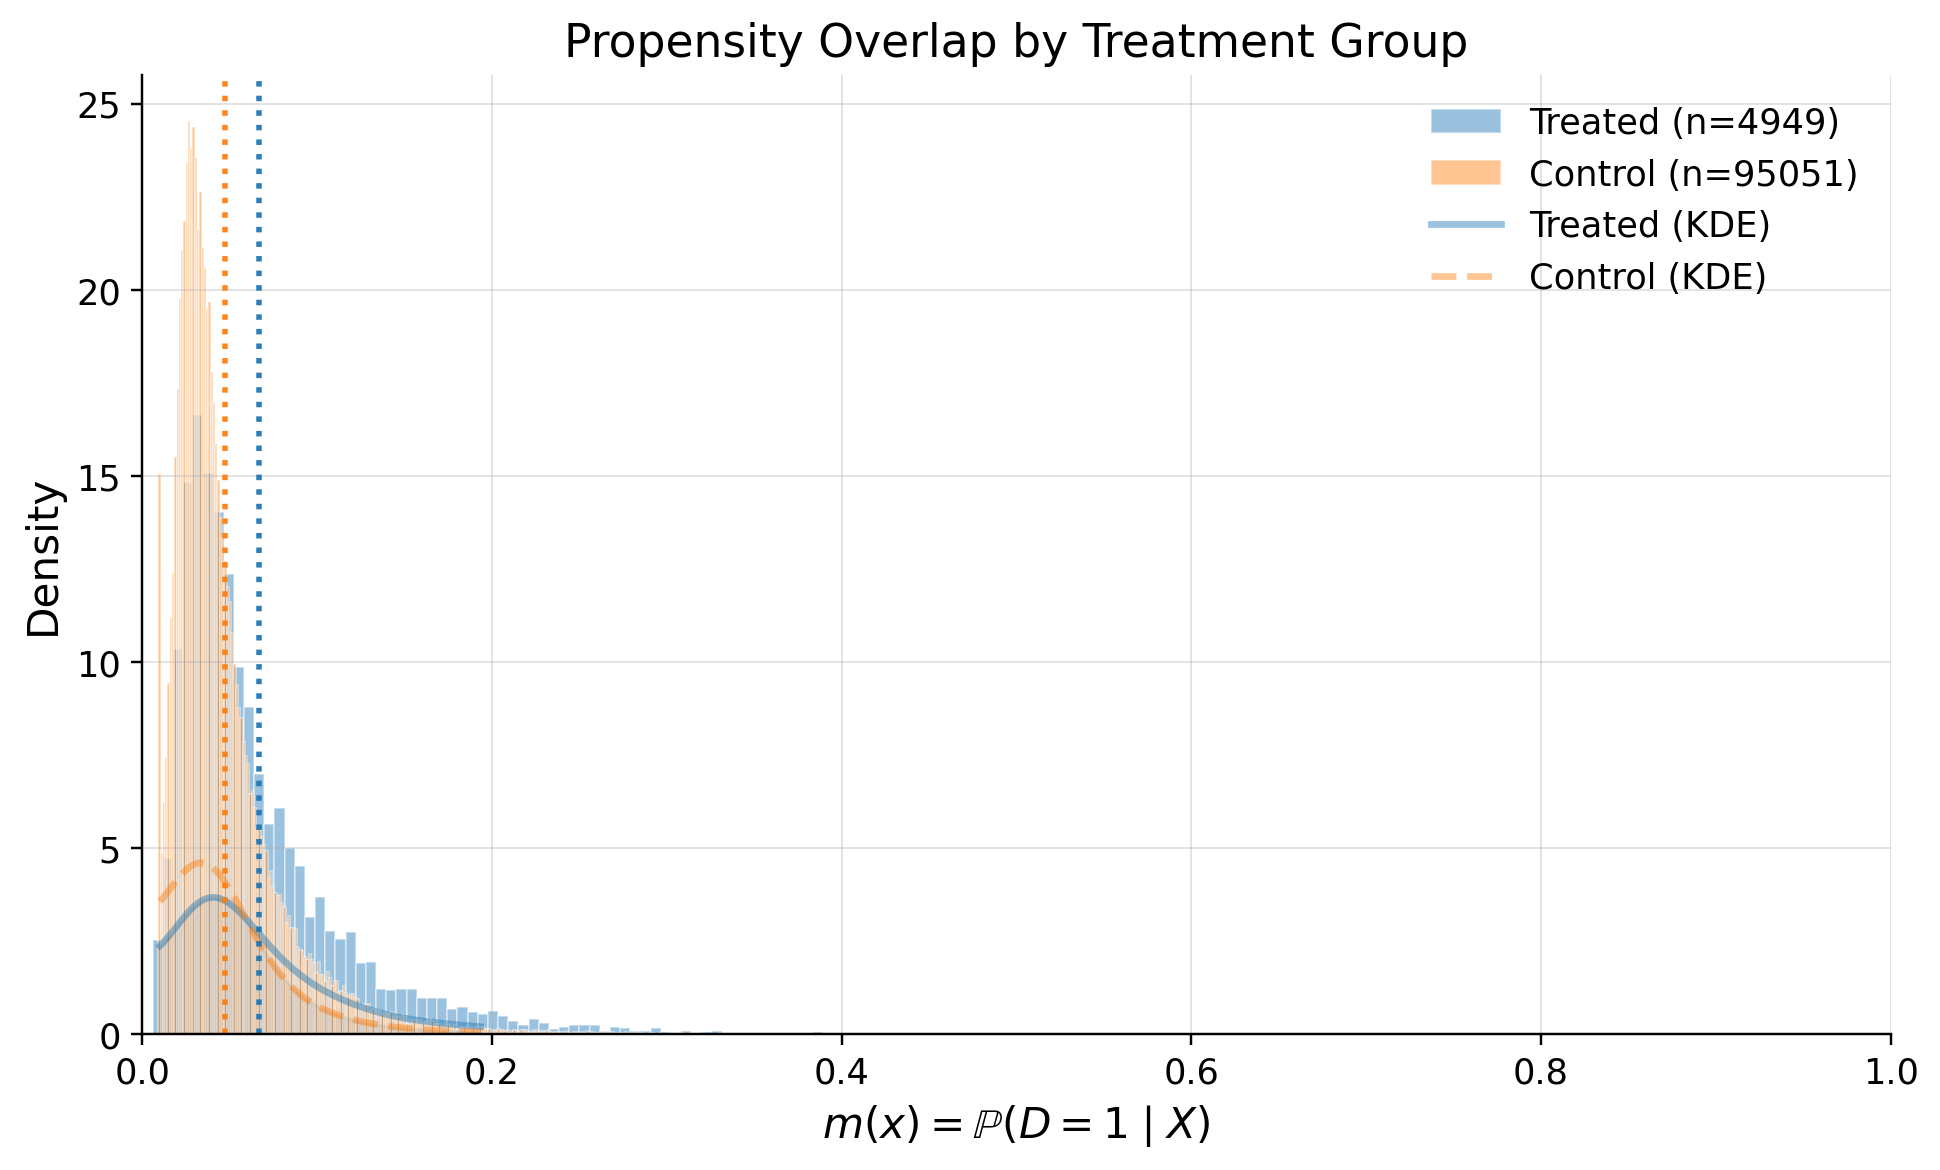

In [20]:
from causalis.scenarios.unconfoundedness.refutation import plot_m_overlap
plot_m_overlap(dml_result)

Customers are not inclined to activate the our product

In [21]:
from causalis.scenarios.unconfoundedness.refutation import run_overlap_diagnostics
rep = run_overlap_diagnostics(causaldata, dml_result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.017440,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.112180,RED
3,edge_0.02_above,0.000000,RED
4,KS,0.194910,GREEN
5,AUC,0.628574,GREEN
6,ESS_treated_ratio,0.503115,GREEN
7,ESS_control_ratio,0.997024,GREEN
8,tails_w1_q99/med,4.899914,YELLOW
9,tails_w0_q99/med,1.183775,GREEN


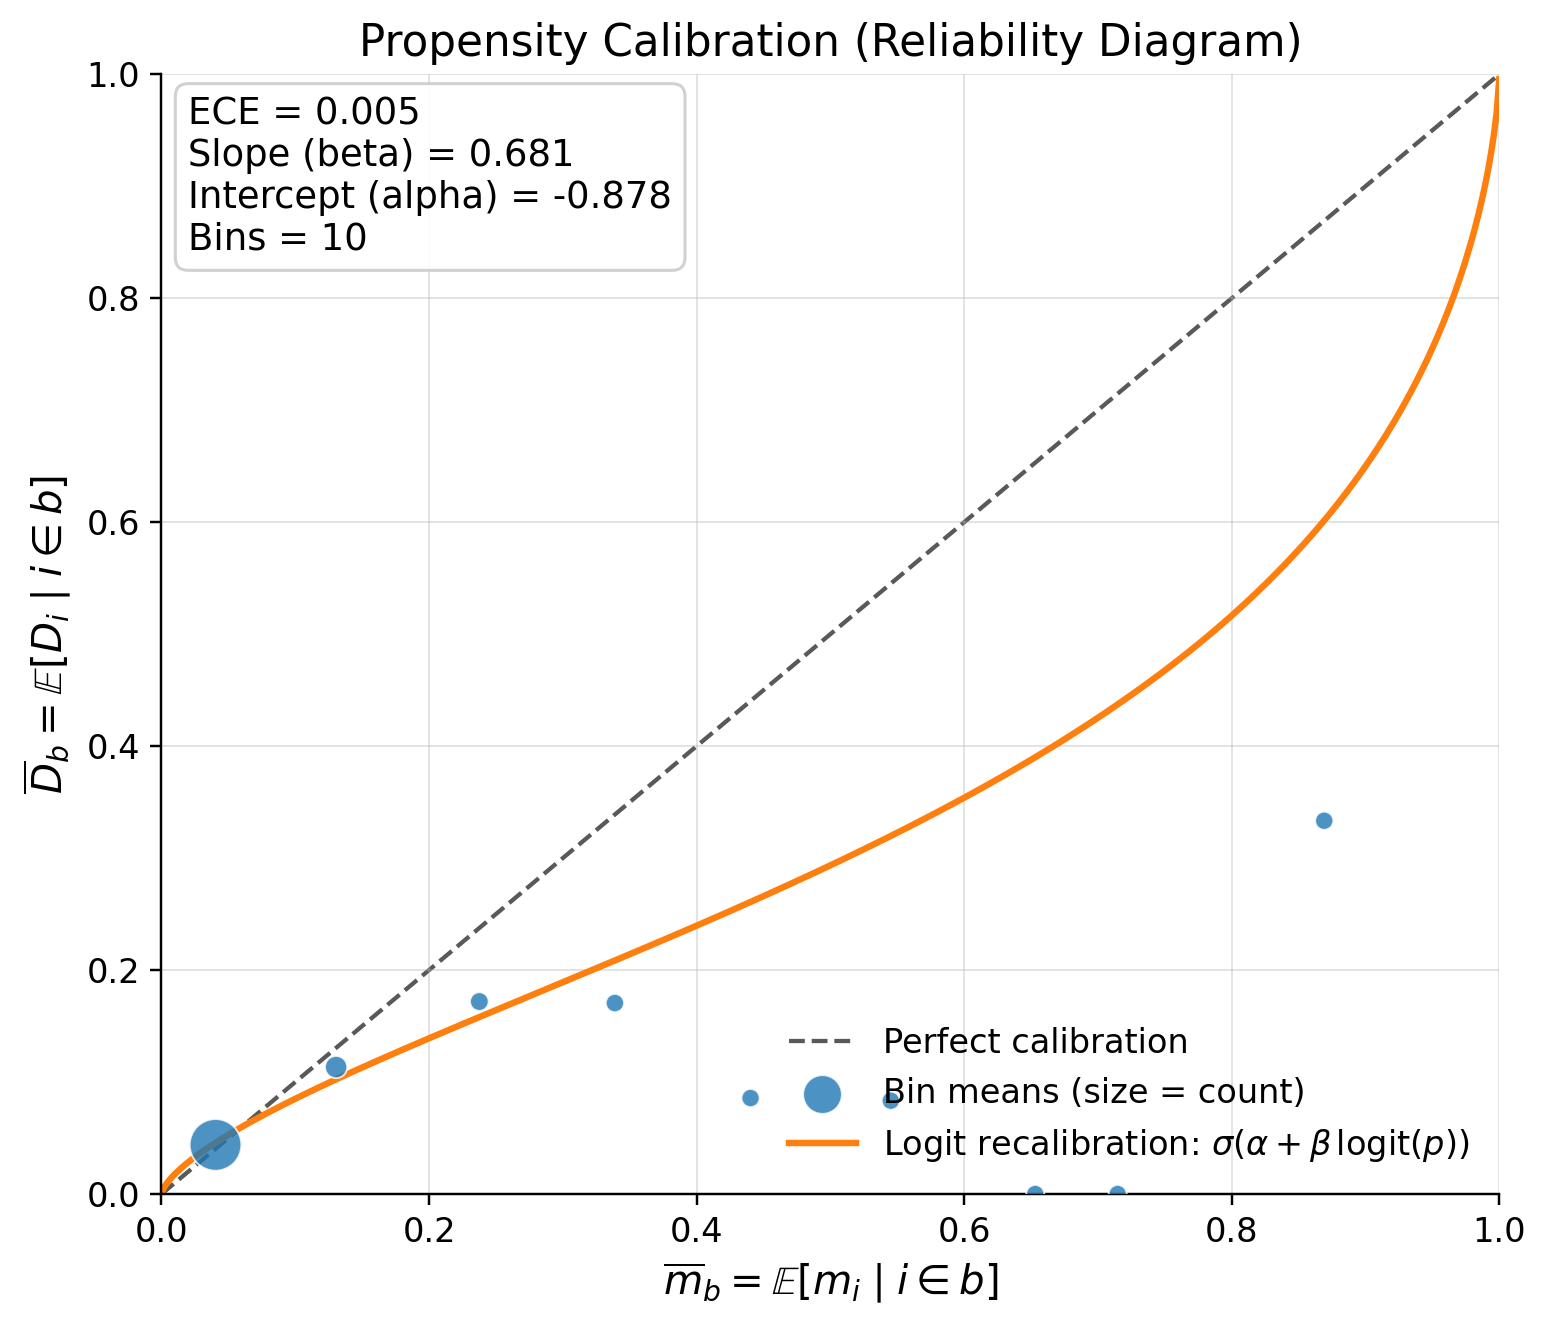

In [22]:
from causalis.scenarios.unconfoundedness.refutation import plot_propensity_reliability
plot_propensity_reliability(dml_result)

# Conclusion

First purchase in our product is increasing LTV 11.7542 (ci_abs: 7.1434, 16.3651) dollars. Model is specified correctly and there is no evidence that assumptions are false